In [224]:
import torch
import torch.nn.functional as F
import numpy as np
from typing import Optional
from torchinfo import summary
import json
import os
from PIL import Image
import sys
import matplotlib.pyplot as plt
import pytransform3d.camera as pc
import pytransform3d.transformations as pt

## 3 Neural Radiance Field Scene Representation

Todo:
- Dataloader:
    - Sample Images
    - Sample Pixels Given Images
    - Do stratified sampling along the ray for this pixel; generating an estimated color

In [225]:
class SyntheticDataloader():
    def __init__(self, pth, item, split="train"):
        
        data_pth = os.path.join(pth + "/" + item)
        
        with open(data_pth + f"/transforms_{split}.json", "r") as data_file:
            data = json.load(data_file)
            data_file.close()
            
        self.transforms = np.stack([image['transform_matrix'] for image in data['frames']], axis=0)
        
        open_image = lambda img: np.asarray(Image.open(data_pth + img + ".png").convert("RGB")) / 255.
        self.images = np.stack([open_image(img['file_path']) for img in data['frames']], axis=0)
        
        self.total_pxs = self.images[0].shape[0] * self.images[0].shape[1]
        self.img_shape = self.images[0].shape[:2]
        self.img_shape = (800, 800)
        
        self.f = (self.img_shape[0] / 2) / np.tan( data['camera_angle_x'] / 2 ) 
        self.cx = -self.img_shape[0] / 2
        self.cy =  self.img_shape[0] / 2
        self.cam2img = np.eye(3)
        self.cam2img[0, 0] = self.cam2img[1, 1] = self.f
        self.cam2img[0, 2] = self.cx
        self.cam2img[1, 2] =  self.cy
    
    def create_rays(self, R, t):
        '''
        R.shape = 3x3
        t.shape = 1x3
        '''
        
        # TODO - do this for a SET of Rotation Matric
        u, v = np.mgrid[0:self.img_shape[0], 0:self.img_shape[1]]
        
        xc = (u - self.cx) / self.f
        yc = (v - self.cy) / self.f
        
        d = np.dstack((xc, yc, np.ones(xc.shape))) @ R
        o = np.ones((*self.img_shape, 1)) @ t
        
        return o, d
    
    def sample_ray(o, d, t):
        pass
        
    
    def __len__(self):
        assert len(self.transforms) == len(self.images)
        return len(self.images)

In [314]:
dataset = SyntheticDataloader(pth="data/nerf_synthetic/", item="hotdog")
_ = dataset.create_rays(np.eye(3), np.array([[1, 2, 3]]))

## 

## 5.1 Positional Encoding
The authors reference the fact that neural networks opt to learn low-frequency functions rather than high-frequency functions; ie they opt for smoothing approximations. This obviously would not yield highly specific & accurate renderings!

To get around this, they employ a positional encoding to project a low-frequency signal to a high-frequency one, using a this positonal encoding as a mapping. They are trying to coax more information out of a smaller amount of information.  

For example, they reference the following formula:
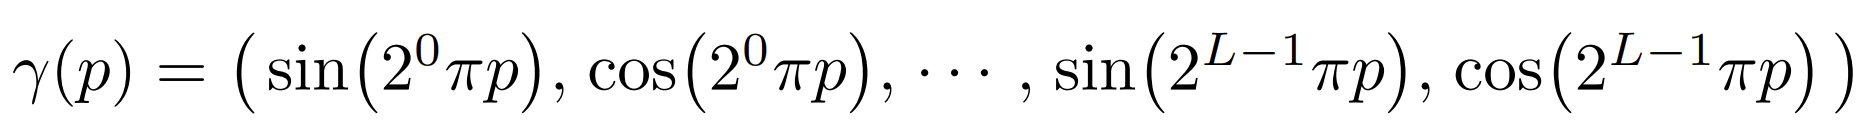

<br>
What this is doing is taking one number, and turning into a vector of length `2L`. If `L`=10, as it is for positional encoding of the camera position, then γ(x) will go from being size 3 to a size 20 vector! This is also why Figure 7 of the original work has the numbers 60 and 24 when referencing γ(x) and γ(d), respectively.

In [352]:
class PositionalEncoding(torch.nn.Module):
    def __init__(self, L: int):
        super().__init__()
        
        self.L = L
        _map = np.array([[(2**i) * np.pi, (2**i) * np.pi] for i in range(L)]).flatten()
        self.register_buffer('map', torch.FloatTensor(_map))
                
    def forward(self, x: torch.Tensor)->torch.Tensor:
        """Generate positional encoding for tensor x.
        Args:
            x (torch.Tensor): (BxNx3) The input vector x (camera position) or d (camera direction)

        Returns:
            torch.Tensor: (BxNx2L) A higher dimensional mapping of the input vector
        """
        
        b, r, xyz = x.shape
        gamma_x = torch.reshape(x[..., None] * self.map, shape=(b, r, self.L*xyz*2))
        gamma_x[...,  ::2] = torch.sin(gamma_x[...,  ::2])
        gamma_x[..., 1::2] = torch.cos(gamma_x[..., 1::2])
        
        return gamma_x
        

In [353]:
# Test for Answer and Shape Naively. Go row by row (x0, y0, z0), (x1, y1, z1), ... and fill in the encoding

L = 10
PE = PositionalEncoding(L=L)
test = torch.randn(size=(10, 64, 3)) 

ans = torch.zeros((10, 64, 2*L * 3))
for ray in range(10):
    for row in range(64):
        for col in range(3):
            
            p = test[ray, row, col]
            
            ans_col = col * 2*L 
            ans[ray, row,  (ans_col):(ans_col + 2*L) : 2] = torch.tensor([ np.sin(2**i * np.pi * p) for i in range(L) ])
            ans[ray, row, (1 + ans_col):(ans_col + 2*L) : 2] = torch.tensor([ np.cos(2**i * np.pi * p) for i in range(L) ])
        
        # ensure all entries are filled out
        assert torch.all(ans[ray, row, (1 + ans_col):(ans_col + 2*L)])

assert torch.allclose(ans, PE(test))

## A: Additional Implementation Details
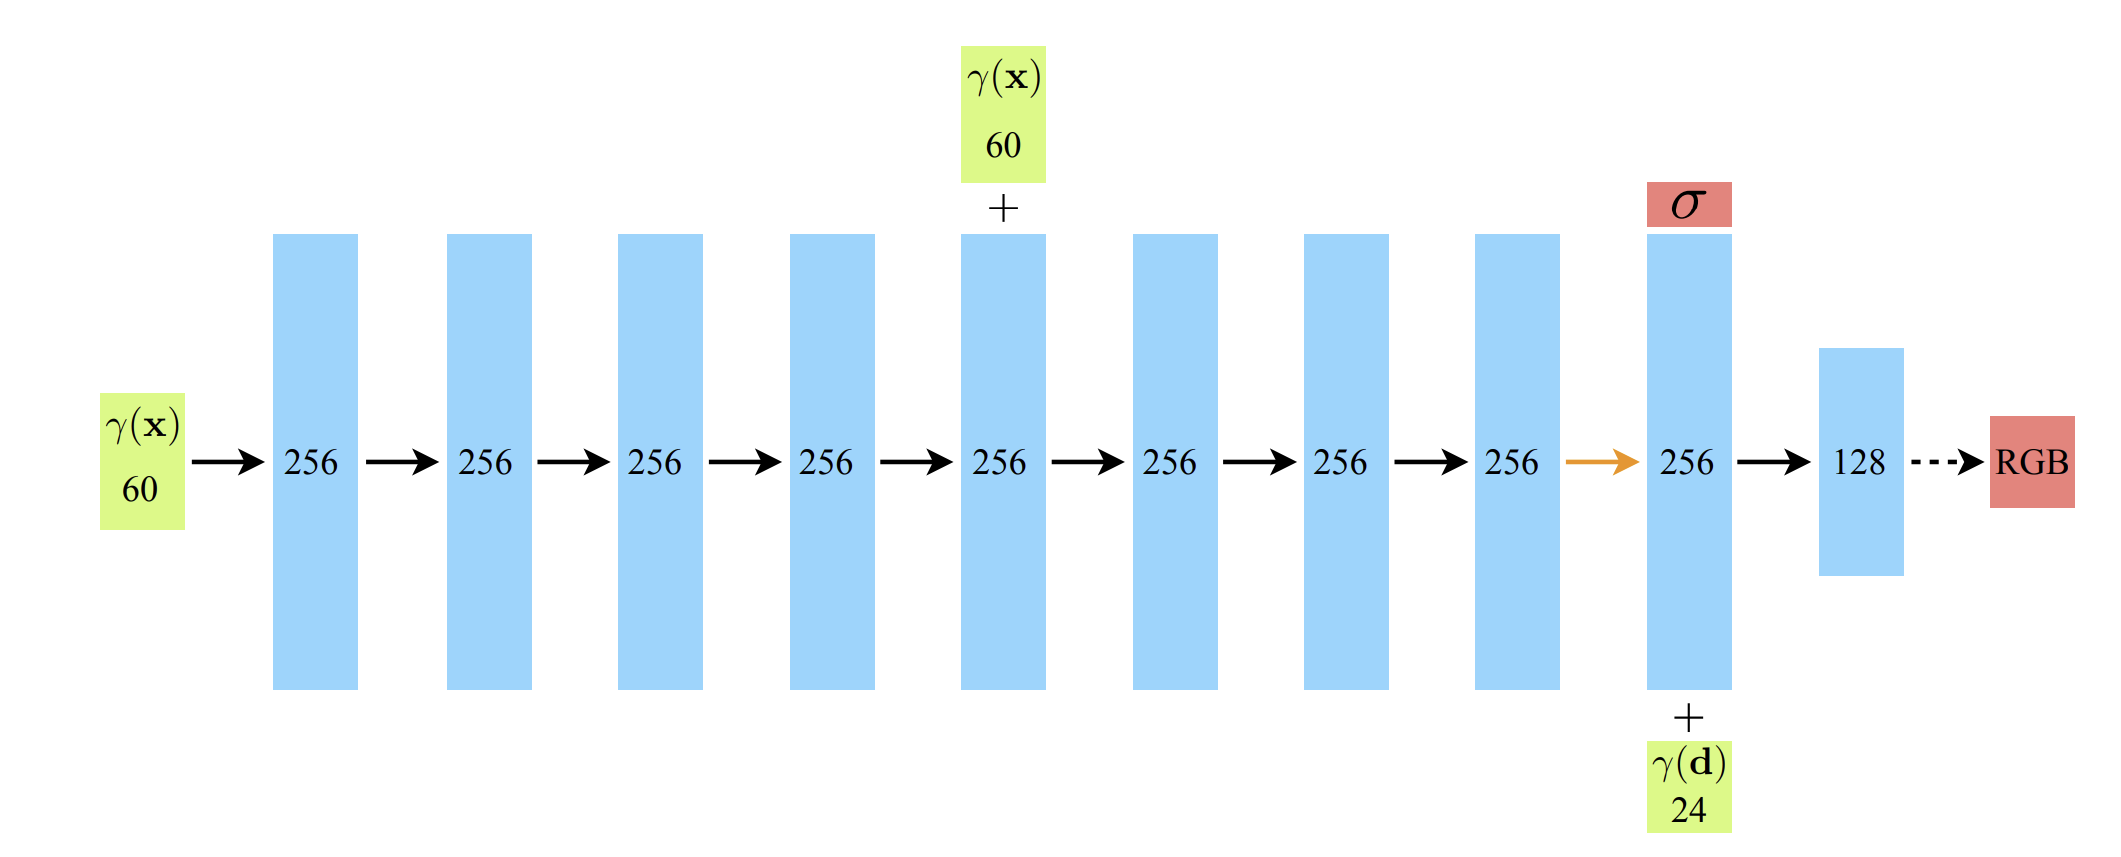

In [355]:
#TODO Add more flexibility, better documentation to these classes

class FFN(torch.nn.Module):
    def __init__(self, in_feats: int, num_layers: int, out_feats: Optional[int]=None):
        super().__init__()
        
        layers = []
        for layer  in range(num_layers):
            if layer == 0:
                layers.append(torch.nn.Linear(in_feats, 256))
            elif out_feats and layer == num_layers-1:
                layers.append(torch.nn.Linear(256, out_feats))
            else:
                layers.append(torch.nn.Linear(256, 256))
                
            layers.append(torch.nn.ReLU())
        
        self.network = torch.nn.Sequential(*layers)
        
    def forward(self, x: torch.Tensor)->torch.Tensor:
        return self.network(x)
        

class NeRF(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        self.model = torch.nn.ModuleDict({
            "x_pe": PositionalEncoding(10),
            "d_pe": PositionalEncoding(4),
            "ffn1": FFN(in_feats=60, num_layers=5),
            "ffn2": FFN(in_feats=60+256, out_feats=257, num_layers=3),
            "proj": torch.nn.Linear(in_features=256+24, out_features=128),
            "out": torch.nn.Linear(in_features=128, out_features=3)
        })
        
    def forward(self, x: torch.Tensor, d: torch.Tensor):
        
        gamma_x = self.model["x_pe"](x)
        
        hidden_feats = torch.cat((gamma_x, self.model["ffn1"](gamma_x)), dim=-1)
        hidden_feats = self.model["ffn2"](hidden_feats)
        
        sigma, feats = hidden_feats[..., 0], hidden_feats[..., 1:]
        
        gamma_d = self.model["d_pe"](d)
        rgb = F.relu(self.model["proj"](torch.cat((feats, gamma_d), dim=-1)))
        
        rgb = F.sigmoid(self.model["out"](rgb))
        
        return sigma, rgb

In [ ]:
coarse, fine = NeRF(), NeRF()
coarse.to("cuda")
fine.to("cuda")
summary(coarse, input_size=((1, 64, 3), (1, 64, 3)), depth=4, col_names=( "input_size", "output_size", "num_params"))
summary(fine, input_size=((1, 64+128, 3), (1, 64+128, 3)), depth=4, col_names=( "input_size", "output_size", "num_params"))

In [ ]:
# stratified sampling

def stratified_sampling(N, tn, tf):
    
    samples = np.random.uniform(low=0, high=(1/N)*(tf - tn), size=(N))
    i = np.arange(0, N)
    
    return tn + (i/N)*(tf - tn) + samples
    

tests = (
    (5, 10, 10),
    (5, 10, 25),
    (1, 100, 25),
    (0, 10, 25),
    (100, 101, 25)
)

def test_stratified_sampling(tests):
    
    for test in tests:
        tn, tf, N = test
        
        samples = stratified_sampling(tn=tn, tf=tf, N=N)
        for i, sample in enumerate(samples):
            lower_bound = tn + (i/N)*(tf-tn) 
            upper_bound = tn + (i+1/N)*(tf-tn) 
            assert lower_bound < sample < upper_bound, f"Sample {i}: {sample} not between {lower_bound, upper_bound}"

In [ ]:
def stratified_sampling_rays(N, tn, tf, rays=3):
    '''
    Stratified samping for a set of rays, returns (rays, N)
    '''
    samples = np.random.uniform(low=0, high=(1/N)*(tf - tn), size=(rays, N))
    i = np.expand_dims(np.arange(0, N), 0)
    
    return tn + (i/N)*(tf - tn) + samples
stratified_sampling_rays(10, 5, 10)

In [ ]:
import time

# o.shape = (px, py, 3) d.shape = (px, py, 3)
o, d = dataset.create_rays(np.eye(3), np.zeros((1, 3)))

rays= 100
rx, ry = np.random.randint(0, dataset.img_shape[0], size=(2, rays))

N = 10
# t.shape = (rays, N)
t = stratified_sampling_rays(tn=5, tf=10, N=N, rays=rays)

testings = 10
start_time = time.time()
result1= None
for i in range(testings):
    print(t.shape, o.shape, d.shape)
    result1 = o[rx, ry][:, None, :] + t[..., None]*d[rx, ry][:, None, :]
    result1 = np.reshape(result1, (-1, 3))
method1 = time.time() - start_time

start_time = time.time()
result2 = None
for i in range(testings):
    of = np.repeat(o[rx, ry], N, 0)
    df = np.repeat(d[rx, ry], N, 0)

    result2 = of + df*t.reshape(-1, 1)
method2 = time.time() - start_time

print(f"Time method 1 {method1:.2f} Time method 2 {method2:.2f}")
np.allclose(result1, result2)

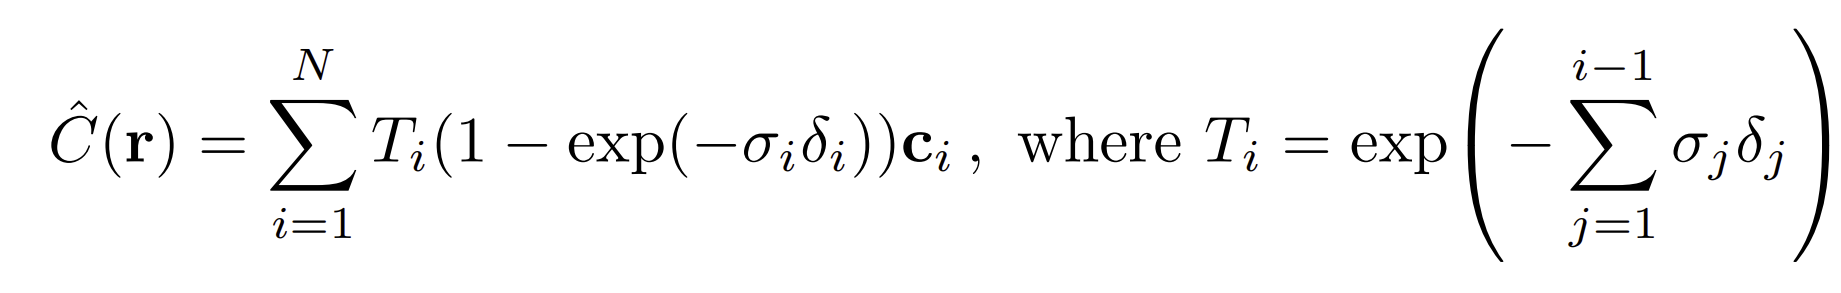
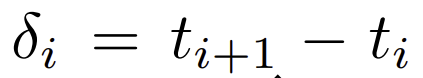

In [ ]:
# sigma.shape = (raysxSamples) ; c.shape (rays, Samples, color) ; t.shape = (rays, Nc)  

def c_pred(sigma, c, t):
    
    delta = torch.diff(t)
    
    Ti = torch.cumsum( torch.exp( -sigma[:, :-1] * delta), dim=-1)
    
    c_hat = torch.sum(Ti[..., None] * (1 - torch.exp(-sigma[:, :-1, None] * delta[..., None])) * c[:, :-1 , :], dim=1)

    return c_hat


In [ ]:
epochs = 3

# select a varies amount of images (1/2 the images at a time)
# select a number of rays that goes cleanly into the 
num_images = 50 
rays_per_image = 100 
Nc = 64
tn, tf = 1, 10

nerf = NeRF()
criterion = torch.nn.MSELoss()

lr = 5e-4
optimizer = torch.optim.Adam(nerf.parameters(), lr=lr, momentum=0.9)
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

# TODO pass in pixels so u can run test and train
def render(pose, u, v):
    
    o, d = dataset.create_rays(pose[:3, :3], pose[:3, 3][None, ...])
    
    t = stratified_sampling_rays(tn=tn, tf=tf, N=Nc, rays=rays_per_image)
    
    x = torch.FloatTensor(o[u, v][:, None, :] + t[..., None]*d[u, v][:, None, :])
    d = torch.FloatTensor(d[u, v][:, None, :]).expand(-1, Nc, -1)
    
    #TODO check
    sigma, c = nerf(x, d)
    
    c_hat = c_pred(sigma, c, torch.FloatTensor(t))

for i in range(epochs):
    
    random_images = np.random.randint(0, len(dataset), num_images)
    
    images, poses = dataset.images[random_images], dataset.transforms[random_images]
    
    
    for pose, image in zip(poses, images):
        
        u, v = np.random.randint(0, dataset.img_shape[0], size=(2, rays_per_image))
        
        c_hat = render(pose, u, v)
        c_true = torch.FloatTensor(image[u, v])
        